# Introduction and Overview
-----

In this assignment, you will recursively estimate the trajectory of a vehicle using available measurements and a motion model. The vehicle is equipped with a LIDAR sensor that returns range and bearing measurements to individual landmarks in the environment. Correspondences between LIDAR measurements and landmarks (i.e., which measurement belongs to which landmark) and the global positions of the landmarks are assumed to be known in advance.

## Motion and Measurement Models
-----

### Motion Model

The motion model makes use of linear and angular velocity odometry readings as inputs, and outputs the predicted vehicle state, which is the 2D poose (position and orientation) of the vehicle:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + \Delta T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$ is the current 2D pose of the vehicle, and
- $v_k$ and $\omega_k$ are the linear and angular velocity odometry readings, which we treat as control inputs.

The process noise $\mathbf{w}_k$ has a normal distribution with a fixed covariance $\mathbf{Q}$.

### Measurement Model

The measurement model relates the current pose of the vehicle to the LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- $x_l$ and $y_l$ are the ground truth coordinates of the landmark $l$
- $x_k$ and $y_k$ and $\theta_{k}$ represent the current pose of the vehicle
- $d$ is the known distance between robot center and laser rangefinder (LIDAR)

The landmark measurement noise $\mathbf{n}^l_k$ has a normal distribution with a constant covariance $\mathbf{R}$.

## Getting Started
-----

Since the models above are nonlinear, we will use the extended Kalman filter (EKF) as our state estimator. You will need to provide code implementing the following two filtering steps:
- the prediction step, which uses odometry measurements and the motion model to produce state and covariance estimates at a given timestep, and
- the correction step, which uses the range and bearing measurements provided by the LIDAR to correct the state estimate.

### Unpack the Data
First, let's unpack the available data that is provided to you in advance:

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

t = data['t']  # timestamps [s]

x_true = data['x_true']  # ground truth x position [m]
y_true = data['y_true']  # ground truth y position [m]
th_true = data['th_true']  # ground truth orientation [rad]

# input signal
v = data['v']  # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# bearing and range measurements, LIDAR constants
b = data['b']  # bearing to each landmark centre in the frame attached to the laser [rad]
r = data['r']  # range measurements [m]
l = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]

(501,)
(501,)
(501, 8)


Note that the distance from the LIDAR frame to the robot center is provided and loaded as an array into the `d` variable.

### Plot the Ground Truth

Ground truth position and orientation information is also available - it's valuable to plot the trajectory before starting the assignment:

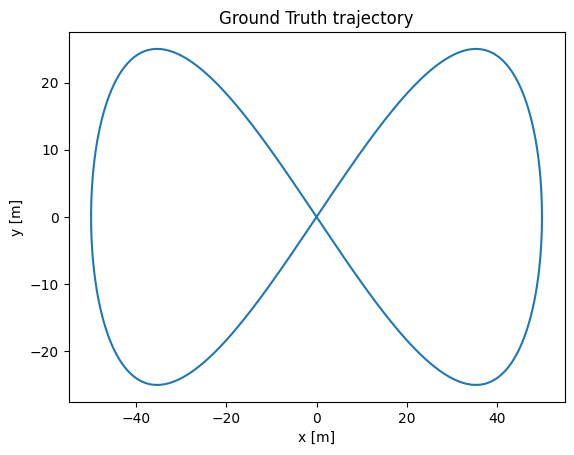

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(x_true, y_true)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Ground Truth trajectory')
plt.show()

### Initialize the Parameters

Now that the data is loaded, we can begin to set up the various estimator parameters. One of the most important aspects of filtering is choosing the motion and measurement noise covariance matrices, as well as the initial state and state covariance. We set the values here:

In [ ]:
v_var = 0.01  # translation velocity variance
om_var = 0.01  # rotational velocity variance
r_var = 0.1  # range measurements variance
b_var = 0.1  # bearing measurement variance

Q_km = np.diag([v_var, om_var]) # input noise covariance
cov_y = np.diag([r_var, b_var])  # measurement noise covariance

x_est = np.zeros([len(v), 3])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices

x_est[0] = np.array([x_true[0], y_true[0], th_true[0]]) # initial state
P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance

**Remember:** that it is neccessary to tune the measurement noise variances `r_var`, `b_var` in order for the filter to perform well.

Also, for the orientation estimates to coincide with the bearing measurements, it is neccessary to wrap all estimated $\theta$ values to the $(-\pi , \pi)$ range. This is because the vehicle orientation lives on the $\mathrm{SO}(2)$ manifold and not in a vector space.

In [ ]:
# Wraps angle to [-pi,pi] range
def wraptopi(x):
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x


## Correction Step
-----
First, let's implement the measurement update function, which takes an available landmark measurement $l$ and updates the current state estimate $\mathbf{\check{x}}_k$.
For each landmark measurement, at a given timestep $k$, you should implement the following:

- Compute the measurement model Jacobians at $\mathbf{\check{x}}_{k}$
\begin{align}
\mathbf{y}^l_k = \mathbf{h}(\mathbf{x}_{k}, \mathbf{n}^l_k) \\\\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}
- Compute the Kalman Gain
\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1}
\end{align}
- Correct the predicted state
\begin{align}
\mathbf{\check{y}}^l_k &= \mathbf{h}\left(\mathbf{\check{x}}_k, \mathbf{0}\right) \\
\mathbf{\hat{x}}_k &= \mathbf{\check{x}}_k + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)
\end{align}
- Correct the covariance
\begin{align}
\mathbf{\hat{P}}_k &= \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

In [ ]:
def measurement_jacobian(xl, yl, x):
    """
    Calculates the Jacobian of the measurement model with respect to the robot's state.
    This Jacobian is used in the EKF to linearize the measurement model around the current state estimate.

    Parameters:
    - xl, yl: Coordinates of the landmark.
    - x: The current state estimate of the robot [x position, y position, orientation].

    Returns:
    - The Jacobian matrix of the measurement model.
    """
    # Extract the current state estimates
    xh, yh, theta = x

    # Calculate the cos and sin of the current orientation for reuse
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # Compute differences in x and y directions factoring in the LiDAR offset
    delta_x = xh - xl + d[0] * cos_theta
    delta_y = yh - yl + d[0] * sin_theta

    # Squared distance between the robot and landmark
    sq_dist = delta_x**2 + delta_y**2

    # Distance between the robot and landmark
    dist = np.sqrt(sq_dist)

    # Components for the Jacobian matrix based on the measurement model
    # Partial derivatives of range w.r.t. state variables
    dr_dx = delta_x / dist
    dr_dy = delta_y / dist
    dr_dtheta = (d[0] * (sin_theta * delta_x - cos_theta * delta_y)) / dist

    # Partial derivatives of bearing w.r.t state variables
    db_dx = -delta_y / sq_dist
    db_dy = delta_x / sq_dist
    db_dtheta = 1 + (d[0] * (cos_theta * delta_y + sin_theta * delta_x)) / sq_dist

    # Assemble the Jacobian matrix from the partial derivatives
    h_jac = np.array([
        [dr_dx, dr_dy, dr_dtheta],
        [db_dx, db_dy, db_dtheta]
    ])

    return h_jac



def measurement_update(lk, rk, bk, P_check, x_check):
    """
    Updates the state estimate and covariance matrix using a new measurement.

    Parameters:
    - lk: Landmark position [xl, yl].
    - rk: Measured range to the landmark.
    - bk: Measured bearing to the landmark.
    - P_check: Predicted state covariance matrix before measurement update.
    - x_check: Predicted state before measurement update.

    Returns:
    - x_hat: Updated state estimate after measurement update.
    - P_hat: Updated state covariance matrix after measurement update.
    """
    # Extract landmark coordinates
    xl, yl = lk

    # Compute the measurement Jacobian matrix at the predicted state
    H = measurement_jacobian(xl, yl, x_check)

    # Measurement noise covariance matrix (assumed known)
    M = np.eye(2)  # Measurement matrix, identity in this case

    # Compute the Kalman Gain
    Kalman_Gain = np.dot(np.dot(P_check, H.T), np.linalg.inv(np.dot(np.dot(H, P_check), H.T) + np.dot(M, np.dot(cov_y, M.T))))

    # Calculate predicted range and bearing to the landmark
    pred_range = np.sqrt((xl - x_check[0] - d[0] * np.cos(x_check[2]))**2 + (yl - x_check[1] - d[0] * np.sin(x_check[2]))**2)
    pred_bearing = np.arctan2(yl - x_check[1] - d[0] * np.sin(x_check[2]), xl - x_check[0] - d[0] * np.cos(x_check[2])) - x_check[2]

    # Innovation or measurement residual
    ylk = np.array([rk - pred_range, wraptopi(bk - pred_bearing)])

    # Update state estimate using the innovation and the Kalman Gain
    x_hat = x_check + np.dot(Kalman_Gain, ylk)

    # Ensure the orientation angle remains within [-pi, pi]
    x_hat[2] = wraptopi(x_hat[2])

    # Update the covariance matrix
    P_hat = np.dot((np.eye(3) - np.dot(Kalman_Gain, H)), P_check)

    return x_hat, P_hat

## Prediction Step and Main Loop
-----
Now, let's code up the main filter loop, implementing the prediction step of the EKF using our motion model:

\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= \mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [ ]:
#### 5. Main Filter Loop #######################################################################
for k in range(1, len(t)):  # start at 1 because we've set the initial prediciton

    delta_t = t[k] - t[k - 1]  # time step (difference between timestamps)

    # 1. Update state with odometry readings (remember to wrap the angles to [-pi,pi])
    x_check = np.zeros(3)

    # 2. Motion model jacobian with respect to last state
    F_km = np.zeros([3, 3])

    # 3. Motion model jacobian with respect to noise
    L_km = np.zeros([3, 2])

    # 4. Propagate uncertainty

    # 5. Update state estimate using available landmark measurements
    for i in range(len(r[k])):
        x_check, P_check = measurement_update(l[i], r[k, i], b[k, i], P_check, x_check)

    # Set final state predictions for timestep
    x_est[k, 0] = x_check[0]
    x_est[k, 1] = x_check[1]
    x_est[k, 2] = x_check[2]
    P_est[k, :, :] = P_check

Let's plot the resulting state estimates:

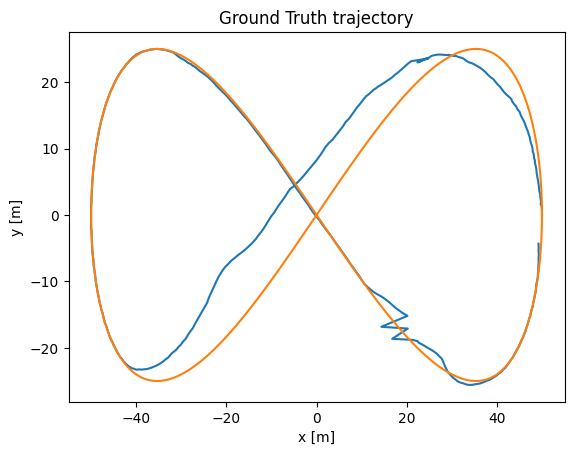

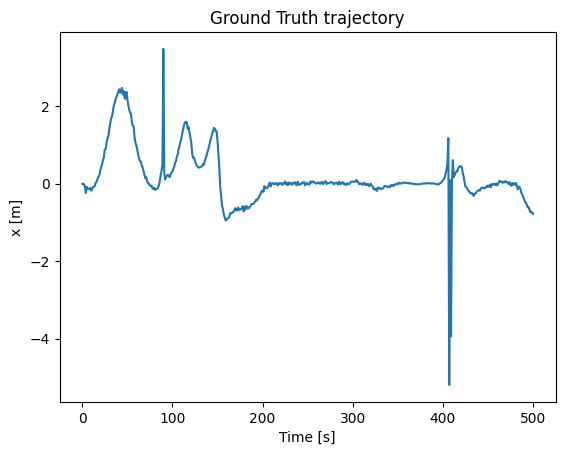

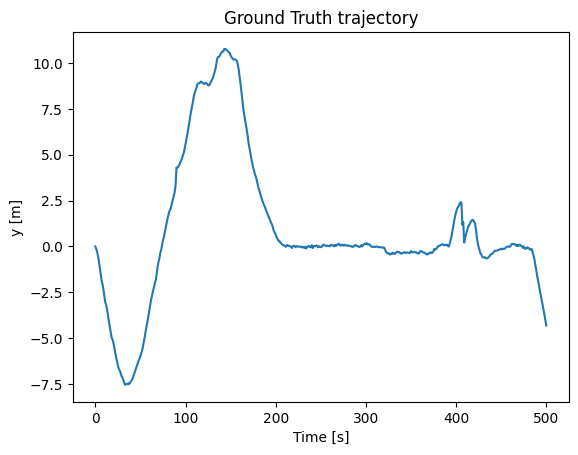

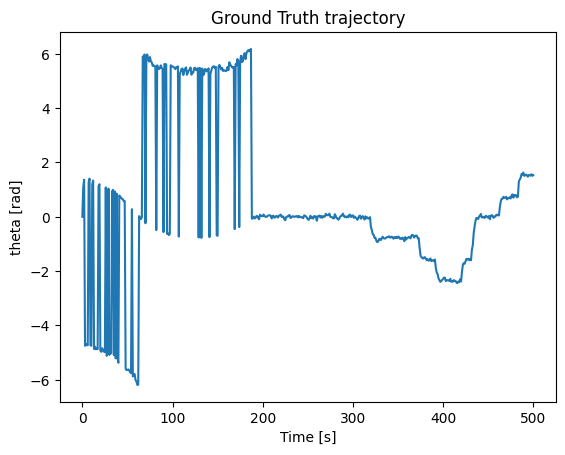

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(x_est[:, 0], x_est[:, 1])
ax.plot(x_true[:], y_true[:])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Ground Truth trajectory')
plt.show()

x_fig = plt.figure()
ax = x_fig.add_subplot(111)
ax.plot(t, (x_est[:, 0]-x_true))
ax.set_xlabel('Time [s]')
ax.set_ylabel('x [m]')
ax.set_title('Ground Truth trajectory')

y_fig = plt.figure()
ax = y_fig.add_subplot(111)
ax.plot(t, (x_est[:, 1]-y_true))
ax.set_xlabel('Time [s]')
ax.set_ylabel('y [m]')
ax.set_title('Ground Truth trajectory')

th_fig = plt.figure()
ax = th_fig.add_subplot(111)
ax.plot(t, (x_est[:, 2]-th_true))
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Ground Truth trajectory')
plt.show()

Are you satisfied wth your results? The resulting trajectory should closely resemble the ground truth trajectory, and the mean state estimate error should be approximately zero. If this is the case, run the code below to produce your solution file.

In [ ]:
with open('submission.pkl', 'wb') as f:
    pickle.dump(x_est, f, pickle.HIGHEST_PROTOCOL)

## Deepening Your Understanding

Now that you have an operating EKF, it's time to go a bit deeper into your results. For this portion of the assignment, you will produce a separate PDF file with plots and some commentary. To complete this portion, you should
- Reduce the set of observations to include Landmark 1 (i.e., index zero) *only*, that is, run the same code as above, with the same initialization, but use measurements from the single landmark (you can simply check and discard other measurements).
- Produce the same plots as above (which will look different, of course) and copy them over to your PDF file.
- Plot the variance of the pose estimate (x, y, theta) at each time step (i.e., as separate plots).
- Respond to the following questions: What happens to the variance of the pose estimate as time goes on? Given that all observations of landmarks are *relative* to the position and orientation of the vehicle, does this trend make sense, or is something else going on?